In [1]:
!git clone https://github.com/jan1na/Neural-Cellular-Automata.git

%cd Neural-Cellular-Automata

Cloning into 'Neural-Cellular-Automata'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 166 (delta 102), reused 79 (delta 42), pack-reused 0 (from 0)
Receiving objects: 100% (166/166), 706.96 KiB | 2.98 MiB/s, done.
Resolving deltas: 100% (102/102), done.
/content/Neural-Cellular-Automata


In [2]:
!pip install medmnist torch torchvision tqdm

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from medmnist import PathMNIST, INFO
from train_utils import train, evaluate, plot_training_history
from models import NCA
import matplotlib.pyplot as plt
import random
import os

# Mount Google Drive
from google.colab import drive

drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.3 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = PathMNIST(split='train', transform=transform, download=True)
val_dataset = PathMNIST(split='val', transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

100%|██████████| 206M/206M [00:13<00:00, 14.7MB/s]


# Dataset Overview

In [4]:
print(f"train_dataset length: {len(train_dataset)}")
print(f"val_dataset length: {len(val_dataset)}")
print(f"Numb classes: {INFO['pathmnist']['label']}")
print(f"Data shape: {train_dataset[0][0].shape}")

train_dataset length: 89996
val_dataset length: 10004
Numb classes: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
Data shape: torch.Size([3, 28, 28])


In [5]:
model_path = '/content/drive/MyDrive/NCA/best_nca_pathmnist.pth'
n_classes = len(INFO['pathmnist']['label'])

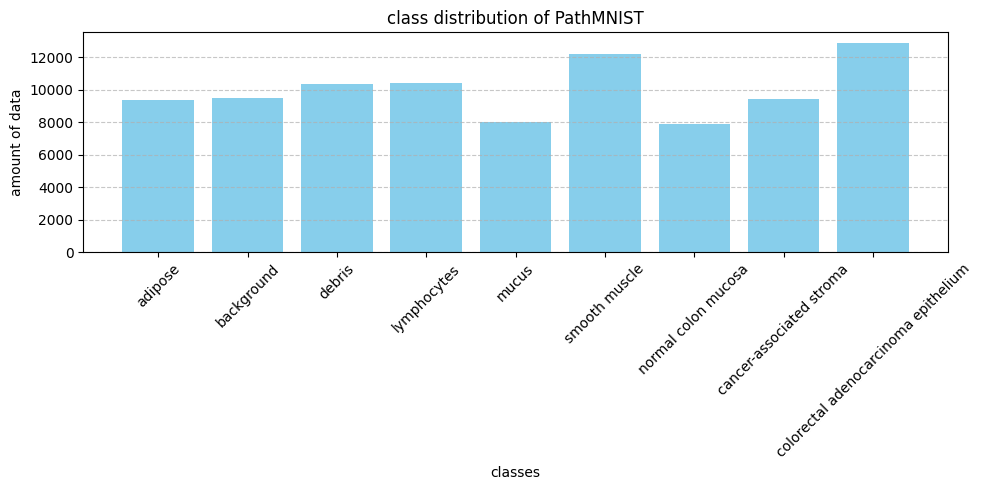

In [6]:
# plotting class distribution

data_dist_path = '/content/drive/MyDrive/NCA/plots/data_distribution.png'

os.makedirs(os.path.dirname(model_path), exist_ok=True)

class_counts = [0] * n_classes

for data, target in train_loader:
    for label in target:
        class_counts[label.item()] += 1

class_labels = list(INFO['pathmnist']['label'].values())
plt.figure(figsize=(10, 5))
plt.bar(class_labels, class_counts, color='skyblue')
plt.title('class distribution of PathMNIST')
plt.xlabel('classes')
plt.ylabel('amount of data')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(data_dist_path, dpi=300)
plt.show()

/tmp/ipython-input-7-3273146053.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(label) == i:


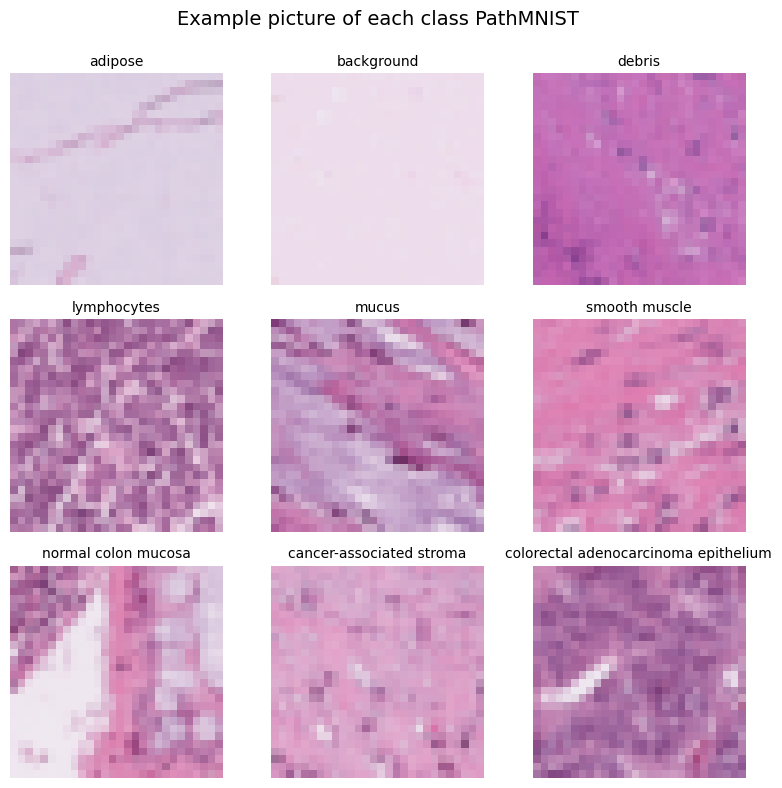

In [7]:
# plotting a picture of each class

test_data_path = '/content/drive/MyDrive/NCA/plots/test_data.png'
os.makedirs(os.path.dirname(model_path), exist_ok=True)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle("Example picture of each class PathMNIST", fontsize=14)

for i, ax in enumerate(axes.flat):

    # searching for random picture and plotting it
    for image, label in train_dataset:
        if int(label) == i:
            img = image.permute(1, 2, 0)
            ax.imshow(img)
            ax.set_title(class_labels[i], fontsize=10)
            ax.axis('off')
            break


plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig(test_data_path, dpi=300)
plt.show()

# Train and plot data

Epoch 01: Train Acc: 0.6799, Val Acc: 0.7718
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 02: Train Acc: 0.8126, Val Acc: 0.8249
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 03: Train Acc: 0.8394, Val Acc: 0.8538
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 04: Train Acc: 0.8550, Val Acc: 0.8854
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 05: Train Acc: 0.8697, Val Acc: 0.8927
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 06: Train Acc: 0.8777, Val Acc: 0.8910


Epoch 07: Train Acc: 0.8865, Val Acc: 0.8667


Epoch 08: Train Acc: 0.8935, Val Acc: 0.9192
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 09: Train Acc: 0.8980, Val Acc: 0.9091


Epoch 10: Train Acc: 0.9033, Val Acc: 0.9177


Epoch 11: Train Acc: 0.9066, Val Acc: 0.9097


Epoch 12: Train Acc: 0.9124, Val Acc: 0.9141


Epoch 13: Train Acc: 0.9140, Val Acc: 0.9127


Epoch 14: Train Acc: 0.9177, Val Acc: 0.9324
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 15: Train Acc: 0.9187, Val Acc: 0.9372
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 16: Train Acc: 0.9218, Val Acc: 0.9200


Epoch 17: Train Acc: 0.9233, Val Acc: 0.9292


Epoch 18: Train Acc: 0.9262, Val Acc: 0.8985


Epoch 19: Train Acc: 0.9281, Val Acc: 0.9369


Epoch 20: Train Acc: 0.9285, Val Acc: 0.9269


Epoch 21: Train Acc: 0.9286, Val Acc: 0.9375
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 22: Train Acc: 0.9314, Val Acc: 0.9436
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 23: Train Acc: 0.9324, Val Acc: 0.9454
New best model saved to /content/drive/MyDrive/NCA/best_nca_pathmnist.pth


Epoch 24: Train Acc: 0.9333, Val Acc: 0.9329


Epoch 25: Train Acc: 0.9343, Val Acc: 0.9388


Epoch 26: Train Acc: 0.9350, Val Acc: 0.9402


Epoch 27: Train Acc: 0.9359, Val Acc: 0.9349


Epoch 28: Train Acc: 0.9352, Val Acc: 0.9439


Epoch 29: Train Acc: 0.9362, Val Acc: 0.9350


Epoch 30: Train Acc: 0.9387, Val Acc: 0.9154


Epoch 31: Train Acc: 0.9391, Val Acc: 0.9362


Epoch 32: Train Acc: 0.9384, Val Acc: 0.9341


Epoch 33: Train Acc: 0.9411, Val Acc: 0.9321
Early stopping triggered.
Training completed.


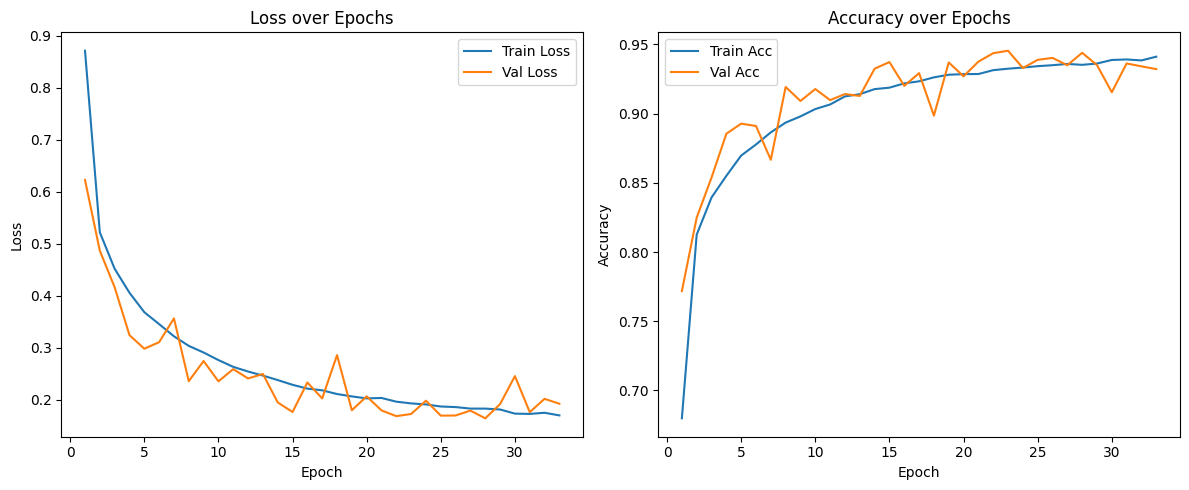

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NCA().to(device)
criterion = nn.CrossEntropyLoss()
NUM_EPOCHS = 100

model_path = '/content/drive/MyDrive/NCA/best_nca_pathmnist.pth'
os.makedirs(os.path.dirname(model_path), exist_ok=True)

plot_save_path = '/content/drive/MyDrive/NCA/plots/nca_training_history.png'
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_acc = 0
patience_counter = 0
patience_limit = 10

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device, is_NCA=True)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, is_NCA=True)

    # Save for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch:02d}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), model_path)
        print(f"New best model saved to {model_path}")
    else:
        patience_counter += 1
        if patience_counter >= patience_limit:
            print("Early stopping triggered.")
            break


print("Training completed.")
plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies, plot_save_path)